# RATINGS PREDICTION

We have a client who has a website where people write different reviews for technical products. Now they are adding a new feature to their website i.e. The reviewer will have to add stars(rating) as well with the review. The rating is out 5 stars and it only has 5 options available 1 star, 2 stars, 3 stars, 4 stars, 5 stars. Now they want to predict ratings for the reviews which were written in the past and they don’t have a rating.

So, we have to build an application which can predict the rating by seeing the review

In [1]:
import pandas as pd # for data wrangling purpose
import numpy as np # Basic computation library
import seaborn as sns # For Visualization 
import matplotlib.pyplot as plt # ploting package
%matplotlib inline
import warnings # Filtering warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing dataset excel file using pandas.
df=pd.read_csv('Rating_Prediction_dataset.csv')

In [3]:
print('No. of Rows :',df.shape[0])
print('No. of Columns :',df.shape[1])
pd.set_option('display.max_columns',None) 
df.head()

No. of Rows : 50000
No. of Columns : 3


,Unnamed: 0,Product_Review,Ratings
0,0,It has great sound quality and bass but after ...,1.0
1,1,"[BIG UPDATE]IT BROKE ALONG THE RIGHT HINGE, I ...",2.0
2,2,This is a premium quality product from boAt-Li...,5.0
3,3,The boAt Rockerz line is boAt's super cheap li...,1.0
4,4,These are super comfortable and premium lookin...,5.0


In [4]:
# Dropping unnecssary index column Unnamed:0 
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product_Review  49920 non-null  object 
 1   Ratings         50000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 781.4+ KB


#### Checking Null values

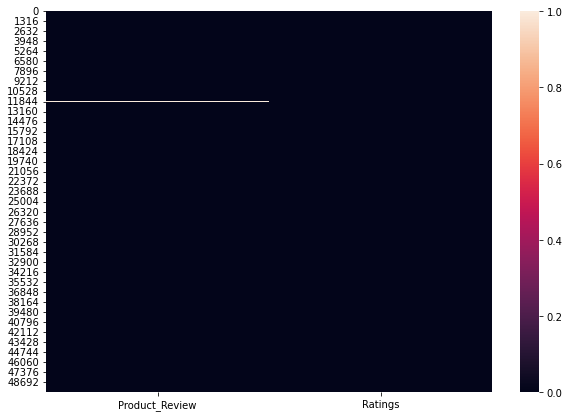

Product_Review    80
Ratings            0
dtype: int64

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull())
plt.show()
df.isnull().sum()

In [9]:
# Replacing missing data with 'Review Not Available' using pandas fillna()
df['Product_Review'].fillna('Review Not Available',inplace=True)

In [10]:
df.isnull().sum().any() 

False

In [11]:
df.isnull().sum()

Product_Review    0
Ratings           0
dtype: int64

### No missing values are present

Exploration of Target Variable Ratings

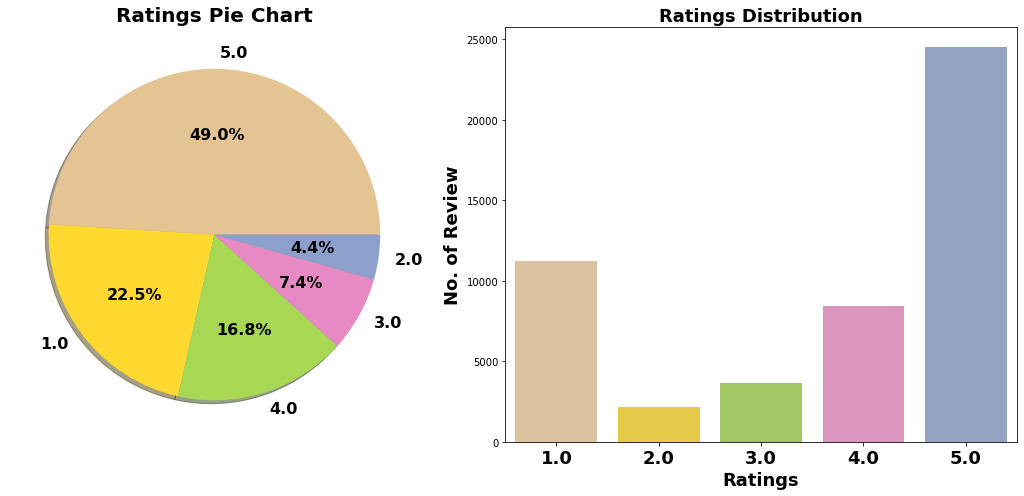

Value Counts of Rating:


5.0    24506
1.0    11232
4.0     8406
3.0     3680
2.0     2176
Name: Ratings, dtype: int64

In [12]:
# Pie & Count plot of Ratings
plt.rcParams["figure.autolayout"] = True
sns.set_palette('Set2_r')
f,ax=plt.subplots(1,2,figsize=(15,7))
df['Ratings'].value_counts().plot.pie(autopct='%2.1f%%',
                                textprops ={'fontsize':16 ,'fontweight' :'bold'}, ax=ax[0],shadow=True)
ax[0].set_title('Ratings Pie Chart', fontsize=20,fontweight ='bold')
ax[0].set_ylabel('')
sns.countplot('Ratings',data=df,ax=ax[1])
ax[1].set_title('Ratings Distribution',fontsize=18,fontweight ='bold')
ax[1].set_xlabel("Ratings",fontsize=18,fontweight ='bold')
ax[1].set_ylabel("No. of Review",fontsize=18,fontweight ='bold')
plt.xticks(fontsize=18,fontweight ='bold')
plt.tight_layout()
plt.show()
print('Value Counts of Rating:')
df['Ratings'].value_counts()

In [13]:
# Average Rating given by user
print("Average rating given by users is " + str(df['Ratings'].mean()))

Average rating given by users is 3.65556


In [15]:
#Importing required libraries
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

In [16]:
def clean_text(df, df_column_name):
    
    #Converting all messages to lowercase
    df[df_column_name] = df[df_column_name].str.lower()

    #Replace email addresses with 'email'
    df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

    #Replace URLs with 'webaddress'
    df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

    #Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
    df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

    #Replace numbers with 'numbr'
    df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

    #Remove punctuation
    df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

    #Replace whitespace between terms with a single space
    df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
    #Remove stopwords
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [18]:
clean_text(df, 'Product_Review')
df['Product_Review'].tail(3)

49997    great product works really fine usually numbr ...
49998    service good would say keep good work goin fli...
49999    buy need bigger coverage buy repeater router c...
Name: Product_Review, dtype: object

In [19]:
#Tokenizing the data using RegexpTokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')
df['Product_Review'] = df['Product_Review'].apply(lambda x: tokenizer.tokenize(x.lower()))
df.head()

,Product_Review,Ratings
0,"[great, sound, quality, bass, numbr, months, u...",1.0
1,"[big, update, broke, along, right, hinge, wear...",2.0
2,"[premium, quality, product, boat, lifestyle, p...",5.0
3,"[boat, rockerz, line, boat, super, cheap, line...",1.0
4,"[super, comfortable, premium, looking, headpho...",5.0


In [27]:
# Lemmatizing and then Stemming with Snowball to get root words and further reducing characters
stemmer = SnowballStemmer("english")
import gensim
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3:
            result.append(lemmatize_stemming(token))
            
    return result

In [33]:
#Processing review with above Function
processed_review = []

for doc in df.Product_Review:
    processed_review.append(preprocess(doc))
    
print(len(processed_review))
processed_review[:3]

50000


[['great',
  'sound',
  'qualiti',
  'bass',
  'numbr',
  'month',
  'use',
  'get',
  'break',
  'without',
  'fall',
  'jerk',
  'wear',
  'normal',
  'get',
  'break',
  'one',
  'side',
  'call',
  'costum',
  'care',
  'servic',
  'repli',
  'come',
  'also',
  'file',
  'complaint',
  'boat',
  'offici',
  'websit',
  'warranti',
  'claim',
  'respond',
  'come',
  'servic',
  'center',
  'approach',
  'claim',
  'numbr',
  'wast'],
 ['big',
  'updat',
  'break',
  'along',
  'right',
  'hing',
  'wear',
  'normal',
  'split',
  'open',
  'one',
  'side',
  'extend',
  'weak',
  'pic',
  'inscud',
  'boat',
  'numbr',
  'break',
  'centr',
  'need',
  'concentr',
  'less',
  'celebr',
  'endors',
  'use',
  'profit',
  'materi',
  'qualiti',
  'control',
  'still',
  'work',
  'tap',
  'metal',
  'sheet',
  'still',
  'give',
  'numbr',
  'star',
  'sound',
  'origin',
  'review',
  'own',
  'boat',
  'product',
  'rockerz',
  'numbr',
  'earphon',
  'best',
  'experi',
  'produc

In [34]:
df['clean_review']=processed_review  #Assigning this to the dataframe
df.head()

,Product_Review,Ratings,clean_review
0,"[great, sound, quality, bass, numbr, months, u...",1.0,"[great, sound, qualiti, bass, numbr, month, us..."
1,"[big, update, broke, along, right, hinge, wear...",2.0,"[big, updat, break, along, right, hing, wear, ..."
2,"[premium, quality, product, boat, lifestyle, p...",5.0,"[premium, qualiti, product, boat, lifestyl, pr..."
3,"[boat, rockerz, line, boat, super, cheap, line...",1.0,"[boat, rockerz, line, boat, super, cheap, line..."
4,"[super, comfortable, premium, looking, headpho...",5.0,"[super, comfort, premium, look, headphon, beau..."


In [35]:
df['Product_Review'] = df['clean_review'].apply(lambda x:' '.join(y for y in x))
df.head()

,Product_Review,Ratings,clean_review
0,great sound qualiti bass numbr month use get b...,1.0,"[great, sound, qualiti, bass, numbr, month, us..."
1,big updat break along right hing wear normal s...,2.0,"[big, updat, break, along, right, hing, wear, ..."
2,premium qualiti product boat lifestyl professi...,5.0,"[premium, qualiti, product, boat, lifestyl, pr..."
3,boat rockerz line boat super cheap lineup budg...,1.0,"[boat, rockerz, line, boat, super, cheap, line..."
4,super comfort premium look headphon beauti des...,5.0,"[super, comfort, premium, look, headphon, beau..."


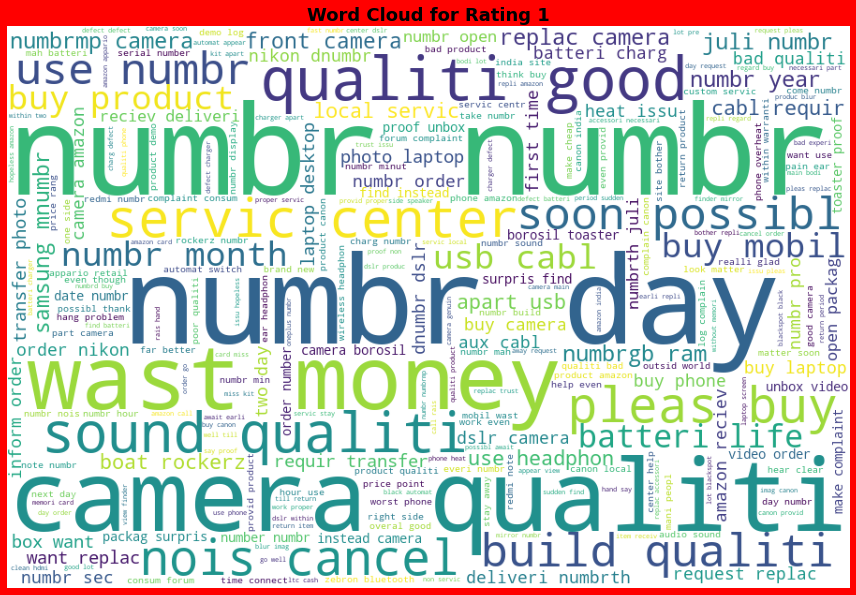

In [36]:
#Getting sense of words in Rating 1
one = df['Product_Review'][df['Ratings']==1.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 1',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

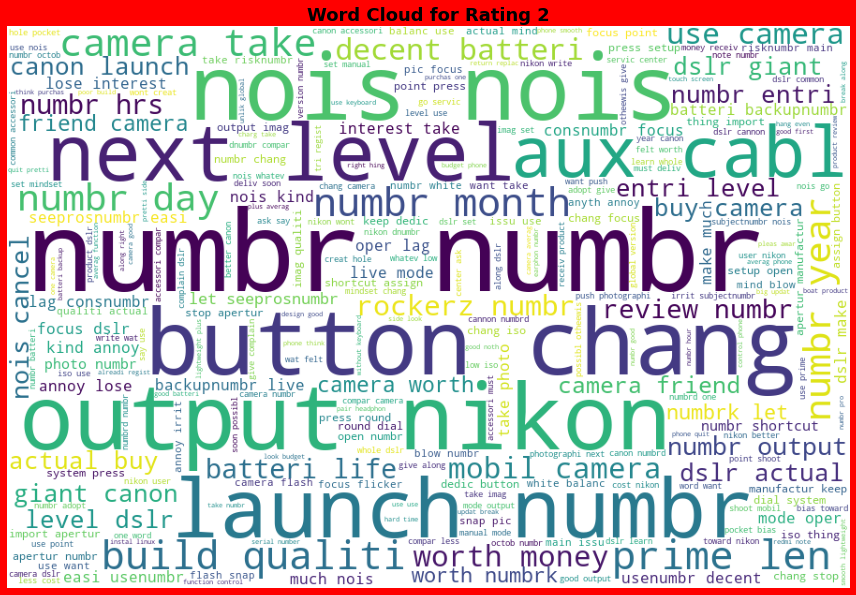

In [37]:
#Getting sense of words in Rating 2
one = df['Product_Review'][df['Ratings']==2.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 2',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

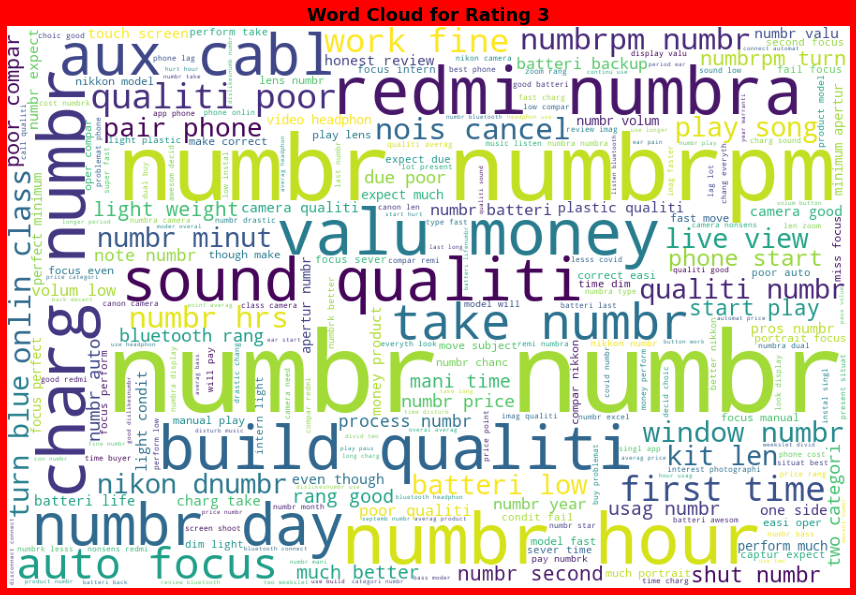

In [38]:
#Getting sense of words in Rating 3
one = df['Product_Review'][df['Ratings']==3.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 3',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

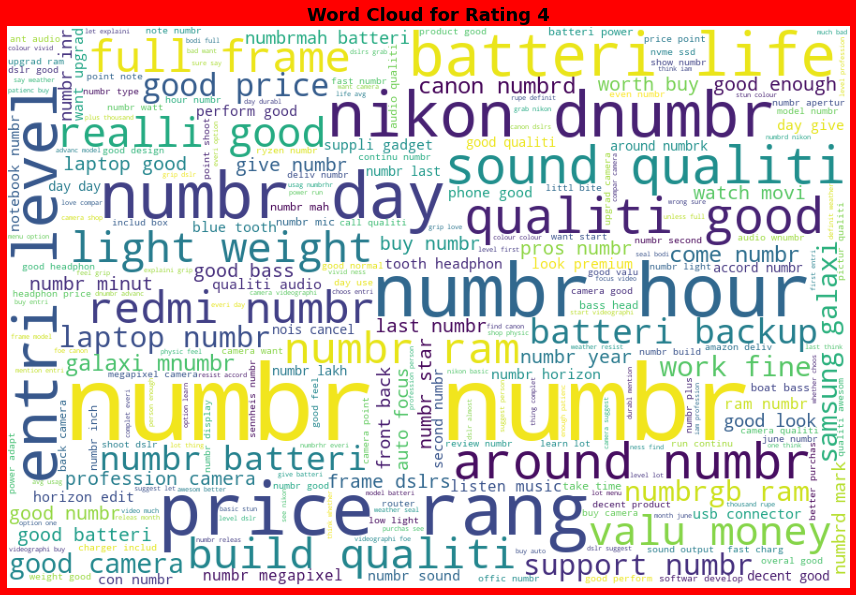

In [39]:
#Getting sense of words in Rating 4
one = df['Product_Review'][df['Ratings']==4.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 4',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

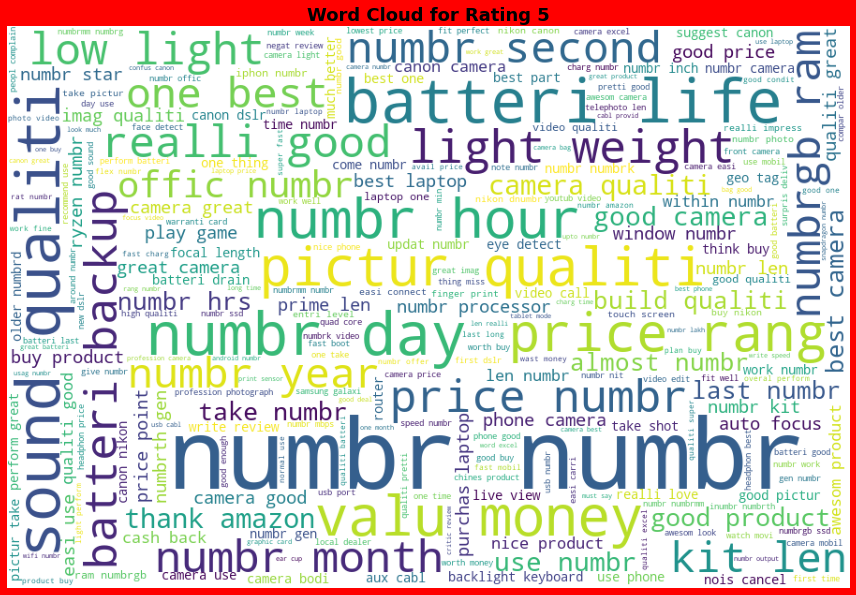

In [40]:
# Getting sense of words in Rating 5
one = df['Product_Review'][df['Ratings']==5.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 5',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

In [41]:
# Converting text into numeric using TfidfVectorizer
tf = TfidfVectorizer()
features = tf.fit_transform(df['Product_Review'])
X=features
Y=df[['Ratings']]

In [42]:
X.shape

(50000, 5828)

In [43]:
Y.shape

(50000, 1)

In [44]:
#Importing Machine learning Model library
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=67, test_size=.3)
print('Training feature matrix size:',X_train.shape)
print('Training target vector size:',Y_train.shape)
print('Test feature matrix size:',X_test.shape)
print('Test target vector size:',Y_test.shape)

Training feature matrix size: (35000, 5828)
Training target vector size: (35000, 1)
Test feature matrix size: (15000, 5828)
Test target vector size: (15000, 1)


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
maxAccu=0
maxRS=0
for i in range(50,100):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3, random_state=i)
    log_reg=LogisticRegression()
    log_reg.fit(X_train,Y_train)
    y_pred=log_reg.predict(X_test)
    acc=accuracy_score(Y_test,y_pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print('Best accuracy is', maxAccu ,'on Random_state', maxRS)

Best accuracy is 0.9071333333333333 on Random_state 71


In [47]:
# Creating train_test_split using best random_state
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=71, test_size=.3)

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=71, test_size=.3)
log_reg=LogisticRegression()
log_reg.fit(X_train,Y_train)
y_pred=log_reg.predict(X_test)
print('\033[1m'+'Logistics Regression Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Logistics Regression :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Logistics Regression :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Logistics Regression'+'\033[0m \n',classification_report(Y_test, y_pred))


Logistics Regression Evaluation


Accuracy Score of Logistics Regression : 0.9071333333333333


Confusion matrix of Logistics Regression : 
 [[3330    7    3    9   29]
 [  35  573    0    2    7]
 [  42    0  820   13  232]
 [  36    3    5 1712  713]
 [ 121    5   16  115 7172]]


classification Report of Logistics Regression 
               precision    recall  f1-score   support

         1.0       0.93      0.99      0.96      3378
         2.0       0.97      0.93      0.95       617
         3.0       0.97      0.74      0.84      1107
         4.0       0.92      0.69      0.79      2469
         5.0       0.88      0.97      0.92      7429

    accuracy                           0.91     15000
   macro avg       0.94      0.86      0.89     15000
weighted avg       0.91      0.91      0.90     15000



In [49]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(log_reg, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', log_reg, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score LogisticRegression() :

CVScore : [0.5435 0.5184 0.6062 0.6375 0.5917]
Mean CV Score : 0.57946
Std deviation : 0.04302309147423043


In [50]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train,Y_train)
y_pred=dtc.predict(X_test)
print('\033[1m'+'Decision Tree Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Decision Tree Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Decision Tree Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Decision Tree Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Decision Tree Classifier Evaluation


Accuracy Score of Decision Tree Classifier : 0.8968


Confusion matrix of Decision Tree Classifier : 
 [[3338    7    3    9   21]
 [  35  573    0    2    7]
 [  40    1  826   34  206]
 [  36    8   19 1810  596]
 [ 124    6   90  304 6905]]


classification Report of Decision Tree Classifier 
               precision    recall  f1-score   support

         1.0       0.93      0.99      0.96      3378
         2.0       0.96      0.93      0.95       617
         3.0       0.88      0.75      0.81      1107
         4.0       0.84      0.73      0.78      2469
         5.0       0.89      0.93      0.91      7429

    accuracy                           0.90     15000
   macro avg       0.90      0.87      0.88     15000
weighted avg       0.90      0.90      0.89     15000



In [51]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(dtc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', dtc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score DecisionTreeClassifier() :

CVScore : [0.4532 0.4771 0.592  0.5521 0.5841]
Mean CV Score : 0.5317
Std deviation : 0.05646489174699619


In [52]:
rfc=RandomForestClassifier()
rfc.fit(X_train,Y_train)
y_pred=rfc.predict(X_test)
print('\033[1m'+'Random Forest Classifier'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Random Forest Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Random Forest Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Random Forest Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Random Forest Classifier


Accuracy Score of Random Forest Classifier : 0.913


Confusion matrix of Random Forest Classifier : 
 [[3338    7    3    9   21]
 [  35  573    0    2    7]
 [  36    0  821   11  239]
 [  28    3    7 1743  688]
 [  92    4   15   98 7220]]


classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

         1.0       0.95      0.99      0.97      3378
         2.0       0.98      0.93      0.95       617
         3.0       0.97      0.74      0.84      1107
         4.0       0.94      0.71      0.80      2469
         5.0       0.88      0.97      0.93      7429

    accuracy                           0.91     15000
   macro avg       0.94      0.87      0.90     15000
weighted avg       0.92      0.91      0.91     15000



In [53]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(rfc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', rfc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score RandomForestClassifier() :

CVScore : [0.5537 0.4886 0.5744 0.6125 0.5824]
Mean CV Score : 0.56232
Std deviation : 0.041415233912172965


In [54]:
adbc=AdaBoostClassifier()
adbc.fit(X_train,Y_train)
y_pred=adbc.predict(X_test)
print('\033[1m'+'AdaBoost Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of AdaBoost Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of AdaBoost Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of AdaBoost Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

AdaBoost Classifier Evaluation


Accuracy Score of AdaBoost Classifier : 0.5932


Confusion matrix of AdaBoost Classifier : 
 [[1433    3   87   65 1790]
 [ 211  201    0   19  186]
 [  63    0  246   39  759]
 [ 133    3    7   41 2285]
 [ 299    5   62   86 6977]]


classification Report of AdaBoost Classifier 
               precision    recall  f1-score   support

         1.0       0.67      0.42      0.52      3378
         2.0       0.95      0.33      0.48       617
         3.0       0.61      0.22      0.33      1107
         4.0       0.16      0.02      0.03      2469
         5.0       0.58      0.94      0.72      7429

    accuracy                           0.59     15000
   macro avg       0.60      0.39      0.42     15000
weighted avg       0.55      0.59      0.52     15000



In [55]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(adbc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score',adbc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score AdaBoostClassifier() :

CVScore : [0.4397 0.4939 0.5635 0.5697 0.5493]
Mean CV Score : 0.52322
Std deviation : 0.04959493522528284


In [56]:
grad_bc=GradientBoostingClassifier()
grad_bc.fit(X_train,Y_train)
y_pred=grad_bc.predict(X_test)
print('\033[1m'+'Gradient Boosting Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Gradient Boosting Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Gradient Boosting Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Gradient Boosting Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Gradient Boosting Classifier Evaluation


Accuracy Score of Gradient Boosting Classifier : 0.9022666666666667


Confusion matrix of Gradient Boosting Classifier : 
 [[3184    7    3    9  175]
 [  22  573    0    2   20]
 [  25    0  820    9  253]
 [  40    3    8 1700  718]
 [ 116    4   10   42 7257]]


classification Report of Gradient Boosting Classifier 
               precision    recall  f1-score   support

         1.0       0.94      0.94      0.94      3378
         2.0       0.98      0.93      0.95       617
         3.0       0.98      0.74      0.84      1107
         4.0       0.96      0.69      0.80      2469
         5.0       0.86      0.98      0.92      7429

    accuracy                           0.90     15000
   macro avg       0.94      0.86      0.89     15000
weighted avg       0.91      0.90      0.90     15000



In [57]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(grad_bc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', grad_bc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score GradientBoostingClassifier() :

CVScore : [0.5625 0.5816 0.6613 0.6594 0.6081]
Mean CV Score : 0.6145799999999999
Std deviation : 0.040083882047526276


In [58]:
from sklearn.model_selection import GridSearchCV

In [59]:
parameter = { 'max_features': ['auto', 'log2'], 
              'criterion':['gini','entropy'],
              'n_estimators': [75,100,150]}

In [60]:
GCV = GridSearchCV(RandomForestClassifier(),parameter,verbose=10)
GCV.fit(X_train,Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 1/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75;, score=0.904 total time= 1.1min
[CV 2/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 2/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75;, score=0.909 total time= 1.1min
[CV 3/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 3/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75;, score=0.905 total time= 1.0min
[CV 4/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 4/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75;, score=0.904 total time=  56.8s
[CV 5/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 5/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75;, score=0.906 total time=  56.7s
[CV 1/5; 2/12] STAR

[CV 5/5; 9/12] END criterion=entropy, max_features=auto, n_estimators=150;, score=0.906 total time= 1.9min
[CV 1/5; 10/12] START criterion=entropy, max_features=log2, n_estimators=75.....
[CV 1/5; 10/12] END criterion=entropy, max_features=log2, n_estimators=75;, score=0.904 total time= 1.1min
[CV 2/5; 10/12] START criterion=entropy, max_features=log2, n_estimators=75.....
[CV 2/5; 10/12] END criterion=entropy, max_features=log2, n_estimators=75;, score=0.911 total time= 1.1min
[CV 3/5; 10/12] START criterion=entropy, max_features=log2, n_estimators=75.....
[CV 3/5; 10/12] END criterion=entropy, max_features=log2, n_estimators=75;, score=0.906 total time= 1.1min
[CV 4/5; 10/12] START criterion=entropy, max_features=log2, n_estimators=75.....
[CV 4/5; 10/12] END criterion=entropy, max_features=log2, n_estimators=75;, score=0.905 total time= 1.1min
[CV 5/5; 10/12] START criterion=entropy, max_features=log2, n_estimators=75.....
[CV 5/5; 10/12] END criterion=entropy, max_features=log2, n_

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [75, 100, 150]},
             verbose=10)

In [61]:
GCV.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 150}

In [62]:
Final_mod = RandomForestClassifier(criterion='entropy',n_estimators= 150,max_features='auto')
Final_mod.fit(X_train,Y_train)
y_pred=Final_mod.predict(X_test)
print('\033[1m'+'Final Random Forest Classifier Model'+'\033[0m')
print('\033[1m'+'Accuracy Score :'+'\033[0m\n', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Random Forest Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'Classification Report of Random Forest Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Final Random Forest Classifier Model
Accuracy Score :
 0.9136


Confusion matrix of Random Forest Classifier : 
 [[3334    7    3    9   25]
 [  35  573    0    2    7]
 [  36    0  821   11  239]
 [  23    3    7 1744  692]
 [  79    4   15   99 7232]]


Classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

         1.0       0.95      0.99      0.97      3378
         2.0       0.98      0.93      0.95       617
         3.0       0.97      0.74      0.84      1107
         4.0       0.94      0.71      0.80      2469
         5.0       0.88      0.97      0.93      7429

    accuracy                           0.91     15000
   macro avg       0.94      0.87      0.90     15000
weighted avg       0.92      0.91      0.91     15000



In [63]:
import joblib
joblib.dump(Final_mod,'Rating_Prediction.pkl')

['Rating_Prediction.pkl']